In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta
from IPython.display import Image

### 1. Experiment Definition

We developed a new webpage and want to test it's effects on purchase conversion. As such we split our users evenly into 2 groups:
1. **Control**: They get the old webpage
2. **Treatment**: They get the new webpage

Metric we want to track:

$$
\text{purchase conversion} = \frac{\text{Converted Users}}{\text{Exposed Users}}
$$

We have 3 weeks of logged exposure/conversion data. Let's define these terms:
1. **Exposure**: A user is bucketed as control or treatment and sees their corresponding page for the first time in the experiment duration
2. **Conversion**: An exposed user makes a purchase within 7 days of being first exposed

Questions you should ask when setting up a test:
- How do you think the experiment will fair?
- Do we have actionable next steps laid out?

### 2. Data Collection

Let's use some A/B testing data: https://www.kaggle.com/saraabdelaal/abtestdata

In [3]:
df = pd.read_csv('dataset/ab_data.csv')

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Each row is logged when user is exposed to a webpage.
- **timestamp**: time the user is first exposed
- **group**: bucket
- **landing_page**: Which page are they seeing
- **converted**: Initialized to 0. Changes to 1 if the user makes a purchase within 7 days of first exposure

In [6]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


### 3. Data Processing



In [7]:
# But there are some repeated exposures for some users
sample = df[df['user_id'].isin([746755,722274])]
sample

,user_id,timestamp,group,landing_page,converted
29073,746755,2017-01-11 01:28:57.083669,control,new_page,1
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0
286566,746755,2017-01-05 03:40:08.457451,control,old_page,0


Get First timestamp for each username. In this dataset, it is the timestamp of first conversion, but in reality, make sure to do one of the following:
1. Get timestamp of first exposure
2. Remove users with multiple buckets

In [8]:
# 1. Get timestamp of first exposure
first_conversion = sample.groupby('user_id')['timestamp'].min().to_frame().reset_index()
sample = sample.merge(first_conversion, on=['user_id', 'timestamp'])
sample

,user_id,timestamp,group,landing_page,converted
0,722274,2017-01-09 21:21:23.638444,control,new_page,0
1,746755,2017-01-05 03:40:08.457451,control,old_page,0


In [9]:
counter = df['user_id'].value_counts()
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

3894 (1.34\%) user_ids have been exposed to the old AND new page. It should be okay to remove them

In [10]:
#2. Remove users with multiple buckets
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

In [11]:
# Add week column to see the data as you would during experiment
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
df.sample()

,user_id,timestamp,group,landing_page,converted,week
67484,944020,2017-01-10 11:02:54.275202,treatment,new_page,1,2


In [12]:
df['week'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64

### 4. Experiment: Frequentist Approach

In [13]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)

# Lift rate is calculated to tell by how much has the treatment_group changed to the control_group
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


#### Chi-Squared Test

$$
H_0: \text{Control and Treatment are independent} \\
H_A: \text{Control and Treatment are not independent} 
$$

In [14]:
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [15]:
contingency_table

array([[ 17220, 126073],
       [ 17025, 126372]], dtype=int64)

In [16]:
# A chi-square (χ2) statistic is a measure of the difference between the observed and expected frequencies of the outcomes of a set of events or variables.
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [17]:
chi, p_value

(1.426794609399621, 0.23228827305833816)

Since the p_value > 0.05, we cannot reject null hypothesis. Hence, we cannot conclude if there exists a relationship between the control and treatment groups.

In [18]:
print(f"{round(p_value * 100, 2)}% probability that a more extreme chi square than {round(chi, 3)} would have occured by chance")

23.23% probability that a more extreme chi square than 1.427 would have occured by chance


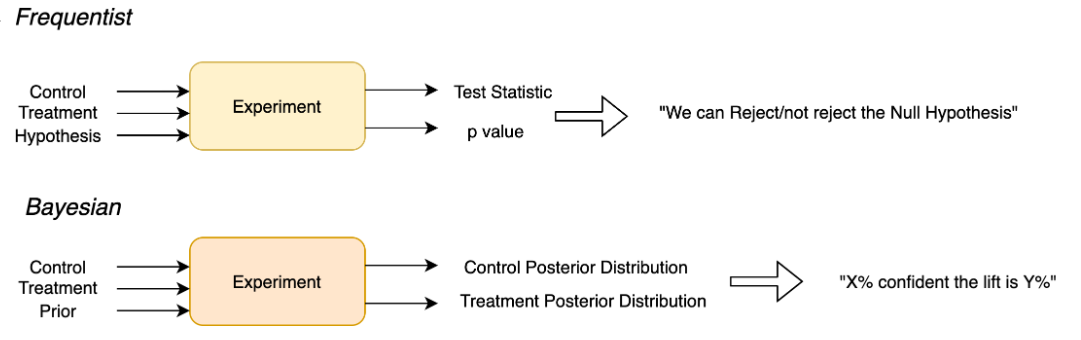